# Simulation of the deadenylation process

### Initial poly(A) length
 1. Nearly identical (normal distribution with small std)
 2. Negative binomial distirbution

In [1]:
# Built-in
from functools import partial
import math

# Third-party
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
import scipy

styles = ['../polya.mplstyle']

#### Scenario 1: Nearly identical

Modes  
1. Constant deadenylation rate
2. Slower on short poly(A) tails
3. Faster on short poly(A) tails

In [7]:
scenario = 1
mode = 3
init_params = 235, 5
init_pAlen_func = scipy.stats.norm
init_pAlen_dist = init_pAlen_func(*init_params).pdf
transcription_rate = 30 # molecules / cycle

deadenylation_rate = {
    1: lambda x: 4,
    2: lambda x: 6 / (1 + math.exp(-0.1*(x - 60))) + 2,
    3: lambda x: 6 / (1 + math.exp(0.1*(x - 150))) + 2
}[mode]

deadenylation_prob = lambda x: 1
decay_prob = lambda x: 1 / (1 + math.exp(x - 25))

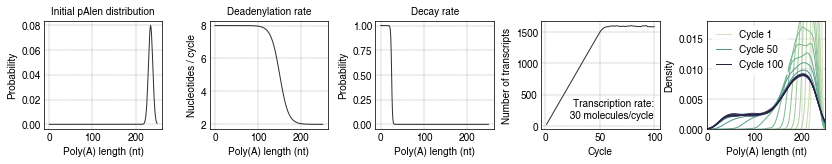

In [8]:
savefig = True
simulate = True

figsize = 14,2


niter = 100
bernoulli_trial = partial(np.random.binomial, 1)

ntags = list()
pool = pd.Series()

with plt.style.context(styles):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=figsize,
                         gridspec_kw={'hspace': 0, 'wspace': 0.4})

    x = pd.Series(np.arange(251))
    axes[0].plot(x, init_pAlen_dist(x))
    axes[0].set_title("Initial pAlen distribution", fontsize="medium")
    axes[0].set_xlabel("Poly(A) length (nt)")
    axes[0].set_ylabel("Probability")
    axes[0].grid(True)
    
    axes[1].plot(x, x.map(deadenylation_rate))
    axes[1].set_title("Deadenylation rate", fontsize="medium")
    axes[1].set_xlabel("Poly(A) length (nt)")
    axes[1].set_ylabel("Nucleotides / cycle")
    axes[1].grid(True)

    axes[2].plot(x, x.map(decay_prob))
    axes[2].set_title("Decay rate", fontsize="medium")
    axes[2].set_xlabel("Poly(A) length (nt)")
    axes[2].set_ylabel("Probability")
    axes[2].grid(True)

    
    if simulate is False:
        plt.show()
        raise SystemExit

    ax = axes[4]
    pal = sns.cubehelix_palette(niter, start=.5, rot=-.75)
    for cycle in range(1, niter+1):
        np.random.seed(cycle)
        
        # Transcription
        transcribed = init_pAlen_func.rvs(*init_params, size=transcription_rate, random_state=cycle)
        pool = pool.append(pd.Series(transcribed), ignore_index=True)

        # Deadenylation
        to_trim = pool.map(deadenylation_prob).map(bernoulli_trial).astype(bool)
        pool.iloc[pool[to_trim].index] -= pool[to_trim].map(deadenylation_rate)

        # Decay
        to_retain = pool.map(decay_prob).map(bernoulli_trial).astype(bool)
        pool = pool[~to_retain]
        
        if (cycle == 1) or (cycle % 5 == 0):
            label = f"Cycle {cycle}" if cycle == 1 or cycle % 50 == 0 else ''
            pool.plot.kde(ax=ax, label=label, color=to_rgba(pal[cycle-1]))
            
        ntags.append(len(pool))
        
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_xlim([0,250])
    ax.grid(True)
    
    ax = axes[3]
    ax.plot(np.arange(1, len(ntags)+1), ntags)
    ax.text(x=0.95, y=0.1, s="Transcription rate:\n {} molecules/cycle".format(transcription_rate),
            ha="right", transform=ax.transAxes)
    ax.set_xlabel("Cycle")
    ax.set_ylabel("Number of transcripts")
    ax.grid(True)
    
    axes[-1].legend()
    axes[-1].set_ylim([0,0.018])
    
    if savefig is True:
        outfigpath = "../plots/simulation_of_deadenylation_scenario-{}_mode-{}.pdf".format(scenario, mode)
        plt.savefig(outfigpath, dpi=300, bbox_inches="tight")
        
    plt.show()

#### Scenario 2: Negative binomial distribution

Modes  
1. Constant deadenylation rate
2. Slower on short poly(A) tails
3. Faster on short poly(A) tails

In [16]:
scenario = 2
mode = 3
n, p = 15, 0.08 
# n, p = 100, 0.37
# n, p = 5, 0.03
init_pAlen_dist = scipy.stats.nbinom.pmf
init_pAlen_func = scipy.stats.nbinom.rvs
transcription_rate = 30 # molecules / cycle
deadenylation_rate = {
    1: lambda x: 4,
    2: lambda x: 6 / (1 + math.exp(-0.1*(x - 60))) + 2,
    3: lambda x: 6 / (1 + math.exp(0.1*(x - 150))) + 2
}[mode]

deadenylation_prob = lambda x: 1.0
decay_prob = lambda x: 1 / (1 + math.exp(x - 25))

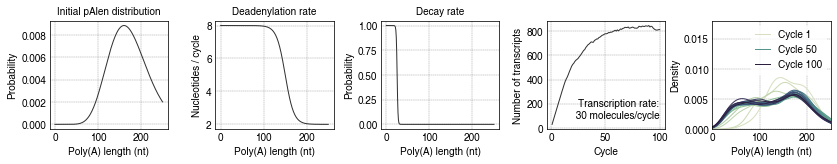

In [17]:
savefig = True
simulate = True

figsize = 14,2


niter = 100
bernoulli_trial = partial(np.random.binomial, 1)

ntags = list()
pool = pd.Series()

with plt.style.context(styles):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=figsize,
                         gridspec_kw={'hspace': 0, 'wspace': 0.4})

    x = pd.Series(np.arange(251))
    axes[0].plot(x, init_pAlen_dist(x,n,p))
    axes[0].set_title("Initial pAlen distribution", fontsize="medium")
    axes[0].set_xlabel("Poly(A) length (nt)")
    axes[0].set_ylabel("Probability")
    axes[0].grid(True)
    
    axes[1].plot(x, x.map(deadenylation_rate))
    axes[1].set_title("Deadenylation rate", fontsize="medium")
    axes[1].set_xlabel("Poly(A) length (nt)")
    axes[1].set_ylabel("Nucleotides / cycle")
    axes[1].grid(True)

    axes[2].plot(x, x.map(decay_prob))
    axes[2].set_title("Decay rate", fontsize="medium")
    axes[2].set_xlabel("Poly(A) length (nt)")
    axes[2].set_ylabel("Probability")
    axes[2].grid(True)
    
#     plt.show()
#     raise SystemExit

    
    if simulate is False:
        plt.show()
        raise SystemExit

    ax = axes[4]
    pal = sns.cubehelix_palette(niter, start=.5, rot=-.75)
    for cycle in range(1, niter+1):
        np.random.seed(cycle)
        
        # Transcription
        transcribed = init_pAlen_func(n, p, size=transcription_rate, random_state=cycle)
        pool = pool.append(pd.Series(transcribed), ignore_index=True)

        # Deadenylation
        to_trim = pool.map(deadenylation_prob).map(bernoulli_trial).astype(bool)
        pool.iloc[pool[to_trim].index] -= pool[to_trim].map(deadenylation_rate)

        # Decay
        to_retain = pool.map(decay_prob).map(bernoulli_trial).astype(bool)
        pool = pool[~to_retain]
        
        if (cycle == 1) or (cycle % 5 == 0):
            label = f"Cycle {cycle}" if cycle == 1 or cycle % 50 == 0 else ''
            pool.plot.kde(ax=ax, label=label, color=to_rgba(pal[cycle-1]))

        ntags.append(len(pool))
        
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_xlim([0,250])
    ax.grid(True)
    
    ax = axes[3]
    ax.plot(np.arange(1, len(ntags)+1), ntags)
    ax.text(x=0.95, y=0.1, s="Transcription rate:\n {} molecules/cycle".format(transcription_rate),
            ha="right", transform=ax.transAxes)
    ax.set_xlabel("Cycle")
    ax.set_ylabel("Number of transcripts")
    ax.grid(True)
    
    axes[-1].legend(loc='upper right')
    axes[-1].set_ylim([0,0.018])
    
    if savefig is True:
        outfigpath = "../plots/simulation_of_deadenylation_scenario-{}_mode-{}.pdf".format(scenario, mode)
        plt.savefig(outfigpath, dpi=300, bbox_inches="tight")
        
    plt.show()